<a href="https://colab.research.google.com/github/Syilun/TibameAI04/blob/master/01lymphoma_CNN_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

In [12]:
IMG_SIZE = 256
class_map = {'CLL':0, 'MCL': 1, 'FL': 2} # 定義類別

In [13]:
# Read single image
data_path = '/content/drive/My Drive/AI tibame/智揚/Day4/lymphoma/*/*.tif'
# data_path = 'drive/My Drive/class/緯育醫學影像/Day4/lymphoma/*/*.tif' 
img_paths = glob(data_path) 
# glob搜尋符合路徑的所有檔案
# img_paths = np.random.choice(img_paths, 100) # 100 images only for demo

print('number of images', len(img_paths))

number of images 374


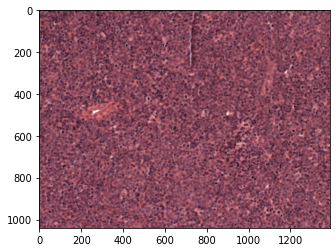

In [10]:
# shape對得起來才能train

img = cv2.imread(img_paths[0])[:,:,::-1] # [:,:,::-1] BGR -> RGB
plt.imshow(img)

((1040, 1388, 3), (256, 256, 3))

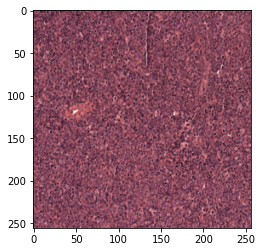

In [14]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [15]:
# Extract img class
img_path = img_paths[0]
img_path

'/content/drive/My Drive/AI tibame/智揚/Day4/lymphoma/MCL/sj-05-901-R1_001.tif'

In [16]:
cls = img_path.split('/')[-2]
cls

'MCL'

In [17]:
class_map[cls]

1

In [18]:
data_count = len(img_paths)
# 轉換成 np.array
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [22]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)[:,:,::-1] # BGR -> RGB
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_resize = img_resize / 255. # normalize 0~255 -> 0~1
    
    # normalize 的時候資料怎麼預處理
    # 後面就要給他一樣的test
    # 1. 0~1
    # 2. -1~1
    # 3. standarization

    cls = path.split('/')[-2]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [20]:
# label count
unique_classes, counts = np.unique(y, return_counts=True)
unique_classes, counts

# 0, 1, 2 不能拿來做訓練，必須one-hot encoding

(array([0., 1., 2.]), array([113, 122, 139]))

In [21]:
# One-hot encoding keras內建的
y = tf.keras.utils.to_categorical(y, num_classes=3)

In [34]:
# Split training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((299, 256, 256, 3), (75, 256, 256, 3), (299, 3), (75, 3))

### Build model

In [25]:
# model 1 自己串，把某層定義好後，將前一層結果到下一層，複雜模型用這個
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = Conv2D(filters=17, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Conv2D(filters=31, kernel_size=3, activation='relu')(x)
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=inputs, outputs=prediction)

In [ ]:
# model2
model2 = tf.keras.models.Sequential()
model2.add(Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
model2.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
model2.add(Conv2D(filters=17, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(filters=31, kernel_size=3, activation='relu'))
model2.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(2))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(3, activation='softmax'))

In [26]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 17)      2465      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 17)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 31)      4774      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 122, 122, 32)      8960      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)       

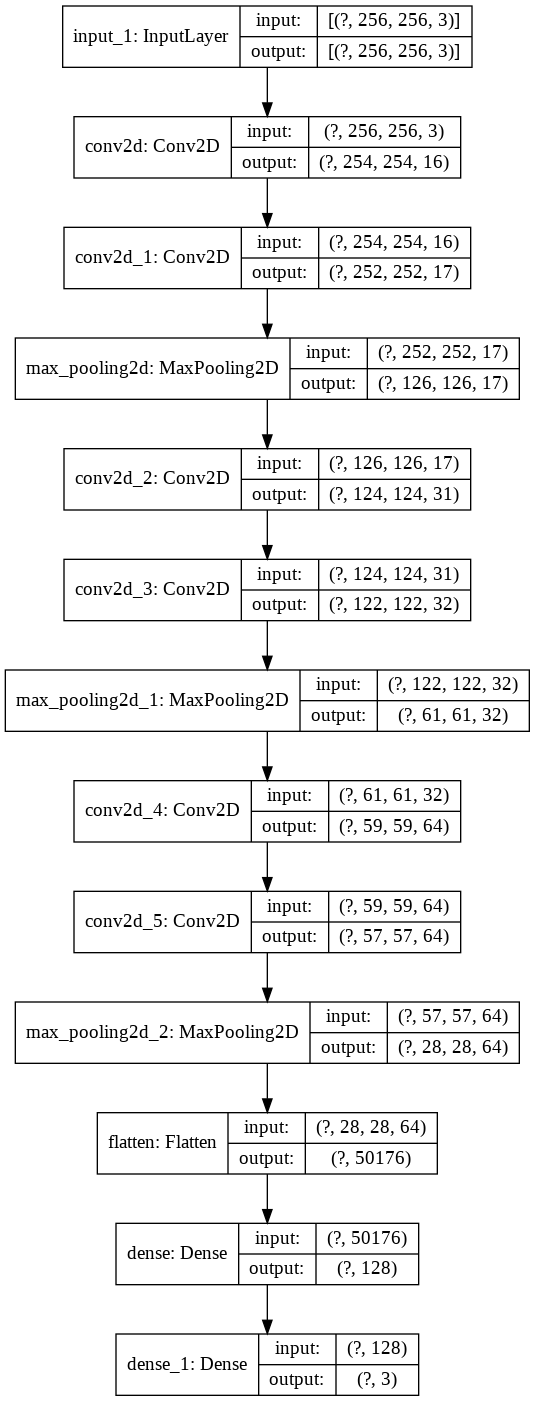

In [27]:
# show model architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, # 'categorical_crossentropy'
              optimizer=tf.keras.optimizers.Adam(), # 'adam'
              metrics=['accuracy'])  # tf.keras.metrics.Accuracy

In [29]:
# batch_size 一次丟幾筆資料 GPU用多少: 模型多複雜 & batch_size有多大
logs = model.fit(X_train, y_train,
                batch_size=16,
                epochs=50,
                verbose=1,
                validation_data=(X_test, y_test))

Epoch 1/50
19/19 [==============================] - 1s 73ms/step - loss: 305.4172 - accuracy: 0.4114 - val_loss: 6111.7070 - val_accuracy: 0.0000e+00
Epoch 2/50
19/19 [==============================] - 1s 43ms/step - loss: 123041.3281 - accuracy: 0.2508 - val_loss: 892420.5625 - val_accuracy: 1.0000
Epoch 3/50
19/19 [==============================] - 1s 42ms/step - loss: 6403368.0000 - accuracy: 0.3211 - val_loss: 20047470.0000 - val_accuracy: 0.0000e+00
Epoch 4/50
19/19 [==============================] - 1s 42ms/step - loss: 115229600.0000 - accuracy: 0.3712 - val_loss: 671220672.0000 - val_accuracy: 0.0000e+00
Epoch 5/50
19/19 [==============================] - 1s 43ms/step - loss: 1795534080.0000 - accuracy: 0.2140 - val_loss: 2583396864.0000 - val_accuracy: 0.0000e+00
Epoch 6/50
19/19 [==============================] - 1s 42ms/step - loss: 9706309632.0000 - accuracy: 0.3211 - val_loss: 32410939392.0000 - val_accuracy: 0.0000e+00
Epoch 7/50
19/19 [==============================] - 1

In [30]:
# 將過程畫出來
history = logs.history

Text(0.5, 1.0, 'acc')

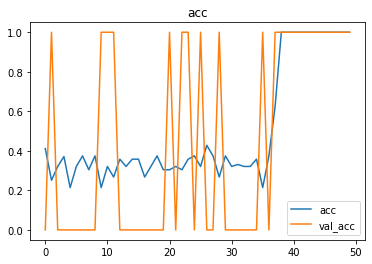

In [31]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

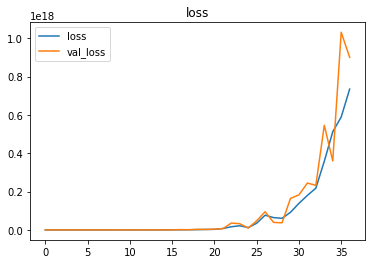

In [32]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

### Metrics

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

model_pred = model.predict(X_test)
y_pred = np.argmax(model_pred, axis=-1)

y_true = np.argmax(y_test, axis=-1)
print(y_true.shape, y_pred.shape)
print('ground truth: ', y_true[:5])
print('model pred: ', y_pred[:5])

In [ ]:
# classification_report
target_names = ['CLL', 'MCL', 'FL']
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
# confusion_matrix
# row: ground truth class
# column: prediction class
print(confusion_matrix(y_true, y_pred))